# Time series project

In [2]:
# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score

In [4]:
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import month_plot, quarter_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima, ARIMA, model_selection

In [5]:
import warnings
warnings.filterwarnings('ignore')

### Step 1. Reading the data set

In [6]:
# Load data
data = pd.read_csv('Aquifer_Petrignano.csv')

### Step 2. Exploration and data cleaning

In [7]:
# Obtain dimensions
data.shape

(5223, 8)

In [8]:
# Obtain information about data types and non-null values
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5223 entries, 0 to 5222
Data columns (total 8 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Date                                  5223 non-null   object 
 1   Rainfall_Bastia_Umbra                 4199 non-null   float64
 2   Depth_to_Groundwater_P24              5168 non-null   float64
 3   Depth_to_Groundwater_P25              5184 non-null   float64
 4   Temperature_Bastia_Umbra              4199 non-null   float64
 5   Temperature_Petrignano                4199 non-null   float64
 6   Volume_C10_Petrignano                 5025 non-null   float64
 7   Hydrometry_Fiume_Chiascio_Petrignano  4199 non-null   float64
dtypes: float64(7), object(1)
memory usage: 326.6+ KB
None


In [9]:
# Visualize the NaN values
data.isnull().sum().sort_values(ascending=False)

Rainfall_Bastia_Umbra                   1024
Temperature_Bastia_Umbra                1024
Temperature_Petrignano                  1024
Hydrometry_Fiume_Chiascio_Petrignano    1024
Volume_C10_Petrignano                    198
Depth_to_Groundwater_P24                  55
Depth_to_Groundwater_P25                  39
Date                                       0
dtype: int64

In [10]:
# Delete the NaN values from the DataFrame
data_dropped=data.dropna().reset_index(drop=True)

In [11]:
data_c=data_dropped.copy()
data_c.head()

,Date,Rainfall_Bastia_Umbra,Depth_to_Groundwater_P24,Depth_to_Groundwater_P25,Temperature_Bastia_Umbra,Temperature_Petrignano,Volume_C10_Petrignano,Hydrometry_Fiume_Chiascio_Petrignano
0,01/01/2009,0.0,-31.96,-31.14,5.2,4.9,-24530.688,2.4
1,02/01/2009,0.0,-32.03,-31.11,2.3,2.5,-28785.888,2.5
2,03/01/2009,0.0,-31.97,-31.07,4.4,3.9,-25766.208,2.4
3,04/01/2009,0.0,-31.91,-31.05,0.8,0.8,-27919.296,2.4
4,05/01/2009,0.0,-31.94,-31.01,-1.9,-2.1,-29854.656,2.3


In [12]:
# Combine the columns with the same features
data_c['Depth_to_Groundwater']=round(((data_c['Depth_to_Groundwater_P24'] + data_c['Depth_to_Groundwater_P25'])/(2)),2)
data_c['Temperature']=round(((data_c['Temperature_Bastia_Umbra'] + data_c['Temperature_Petrignano'])/(2)),2)

In [13]:
# Remove not useful columns
data_c = data_c.drop(columns=['Depth_to_Groundwater_P24', 'Depth_to_Groundwater_P25', 'Temperature_Bastia_Umbra', 'Temperature_Petrignano'])

In [14]:
# Simplify column names
data_c.columns= ['Date', 'Rainfall', 'Volume',	'Hydrometry',	'Depth_to_Groundwater',	'Temperature']

In [15]:
# Ordering the columns of the DataFrame
data_c=data_c.reindex(['Date', 'Rainfall',	'Temperature', 'Hydrometry', 'Volume', 'Depth_to_Groundwater'], axis=1)
data_c.head()

,Date,Rainfall,Temperature,Hydrometry,Volume,Depth_to_Groundwater
0,01/01/2009,0.0,5.05,2.4,-24530.688,-31.55
1,02/01/2009,0.0,2.40,2.5,-28785.888,-31.57
2,03/01/2009,0.0,4.15,2.4,-25766.208,-31.52
3,04/01/2009,0.0,0.80,2.4,-27919.296,-31.48
4,05/01/2009,0.0,-2.00,2.3,-29854.656,-31.48


In [47]:
# Changing the format to the 'Date' column
data_c['Date'] = pd.to_datetime(data_c['Date'], format = '%d/%m/%Y')
data_c = data_c.set_index('Date')
data_c.head()

,Rainfall,Temperature,Hydrometry,Volume,Depth_to_Groundwater
Date,,,,,
2009-01-01,0.0,5.05,2.4,-24530.688,-31.55
2009-01-02,0.0,2.40,2.5,-28785.888,-31.57
2009-01-03,0.0,4.15,2.4,-25766.208,-31.52
2009-01-04,0.0,0.80,2.4,-27919.296,-31.48
2009-01-05,0.0,-2.00,2.3,-29854.656,-31.48


In [49]:
data_c.index

DatetimeIndex(['2009-01-01', '2009-01-02', '2009-01-03', '2009-01-04',
               '2009-01-05', '2009-01-06', '2009-01-07', '2009-01-08',
               '2009-01-09', '2009-01-10',
               ...
               '2020-06-21', '2020-06-22', '2020-06-23', '2020-06-24',
               '2020-06-25', '2020-06-26', '2020-06-27', '2020-06-28',
               '2020-06-29', '2020-06-30'],
              dtype='datetime64[ns]', name='Date', length=4150, freq=None)

In [50]:
# Setting the Frequency
data_c = data_c.asfreq("D")
data_c.index

DatetimeIndex(['2009-01-01', '2009-01-02', '2009-01-03', '2009-01-04',
               '2009-01-05', '2009-01-06', '2009-01-07', '2009-01-08',
               '2009-01-09', '2009-01-10',
               ...
               '2020-06-21', '2020-06-22', '2020-06-23', '2020-06-24',
               '2020-06-25', '2020-06-26', '2020-06-27', '2020-06-28',
               '2020-06-29', '2020-06-30'],
              dtype='datetime64[ns]', name='Date', length=4199, freq='D')

In [16]:
ts = data_c[['Date', 'Depth_to_Groundwater']]

In [17]:
# Changing the format to the 'Date' column
ts['Date'] = pd.to_datetime(ts['Date'], format = '%d/%m/%Y')
ts = ts.set_index('Date')
ts.head()

,Depth_to_Groundwater
Date,
2009-01-01,-31.55
2009-01-02,-31.57
2009-01-03,-31.52
2009-01-04,-31.48
2009-01-05,-31.48


In [18]:
initial_date = ts.index[0]
final_date   = ts.index[-1]
print(f'Initial date: {initial_date}')
print(f'Final date  : {final_date}')

Initial date: 2009-01-01 00:00:00
Final date  : 2020-06-30 00:00:00


In [19]:
ts.index

DatetimeIndex(['2009-01-01', '2009-01-02', '2009-01-03', '2009-01-04',
               '2009-01-05', '2009-01-06', '2009-01-07', '2009-01-08',
               '2009-01-09', '2009-01-10',
               ...
               '2020-06-21', '2020-06-22', '2020-06-23', '2020-06-24',
               '2020-06-25', '2020-06-26', '2020-06-27', '2020-06-28',
               '2020-06-29', '2020-06-30'],
              dtype='datetime64[ns]', name='Date', length=4150, freq=None)

In [20]:
# Setting the Frequency
ts = ts.asfreq("D")
ts.index

DatetimeIndex(['2009-01-01', '2009-01-02', '2009-01-03', '2009-01-04',
               '2009-01-05', '2009-01-06', '2009-01-07', '2009-01-08',
               '2009-01-09', '2009-01-10',
               ...
               '2020-06-21', '2020-06-22', '2020-06-23', '2020-06-24',
               '2020-06-25', '2020-06-26', '2020-06-27', '2020-06-28',
               '2020-06-29', '2020-06-30'],
              dtype='datetime64[ns]', name='Date', length=4199, freq='D')

In [21]:
ts['Depth_to_Groundwater'] = ts['Depth_to_Groundwater'].interpolate(method='linear')

### Step 3. Analysis of a time series

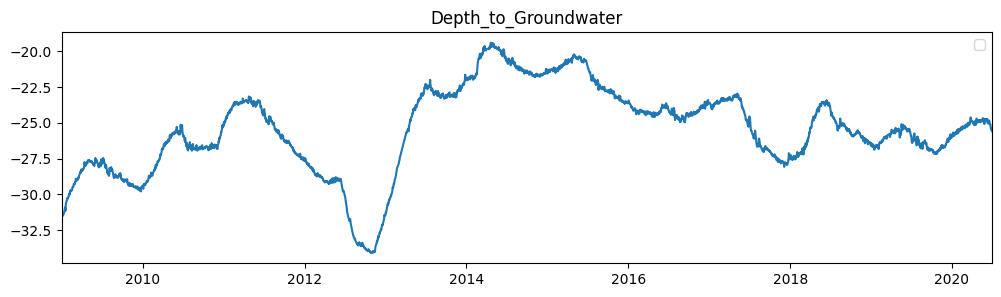

In [22]:
# Plot training and forecast
plt.figure(figsize=(12,3))
plt.plot(ts['Depth_to_Groundwater'])
plt.title('Depth_to_Groundwater')
plt.xlim(initial_date, final_date)
plt.legend()
plt.show()

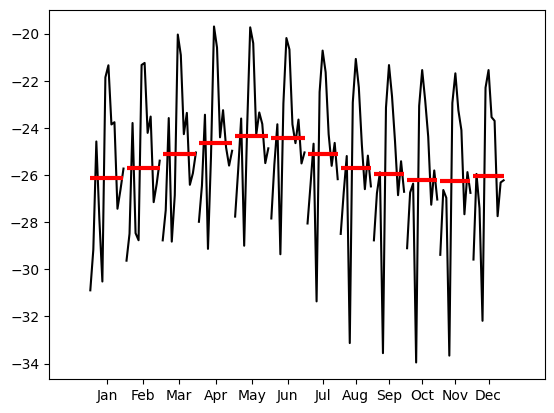

In [23]:
# Plotting the monthly seasonality
month_plot(ts['Depth_to_Groundwater'].resample('M').mean());

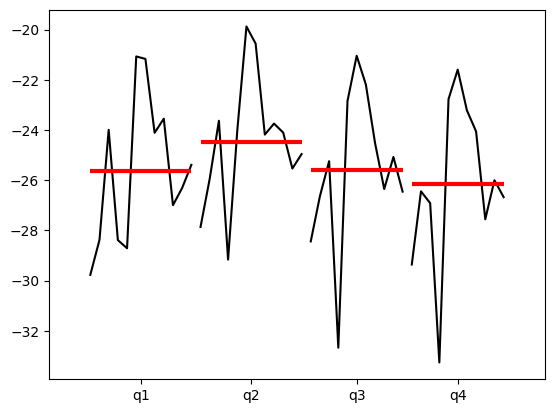

In [24]:
# Plotting the quarterly seasonality
quarter_plot(ts['Depth_to_Groundwater'].resample('Q').mean());

<function matplotlib.pyplot.show(close=None, block=None)>

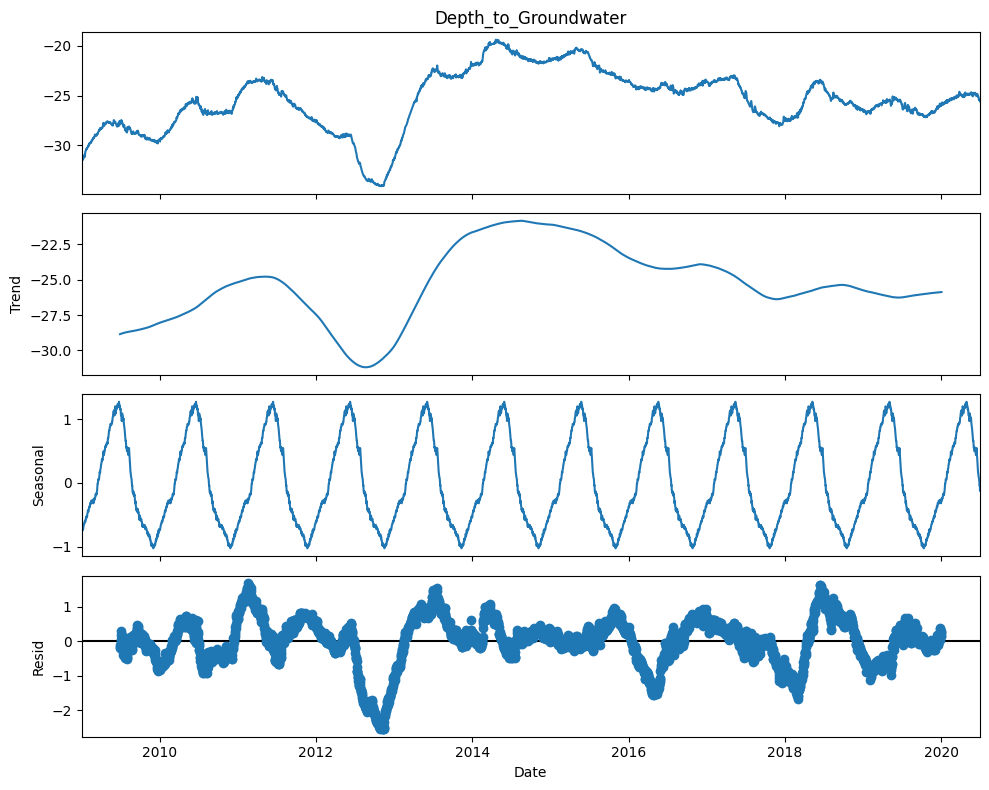

In [25]:
# Time Series Decomposition
decomposition = seasonal_decompose(ts['Depth_to_Groundwater'], model='add', period = 360) 
fig = decomposition.plot()
fig.set_size_inches(10, 8)
plt.xlabel("Date")
plt.tight_layout()
plt.show

Autocorrelation analysis

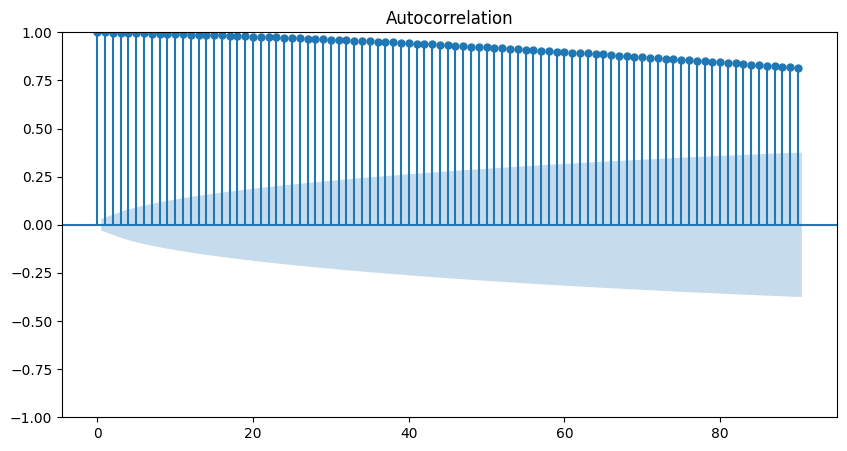

In [26]:
# Plotting the Auto-correlation (ACF)
fig, ax = plt.subplots(figsize = (10, 5))
plot_acf(ts['Depth_to_Groundwater'], lags = 90, ax = ax)
plt.show()

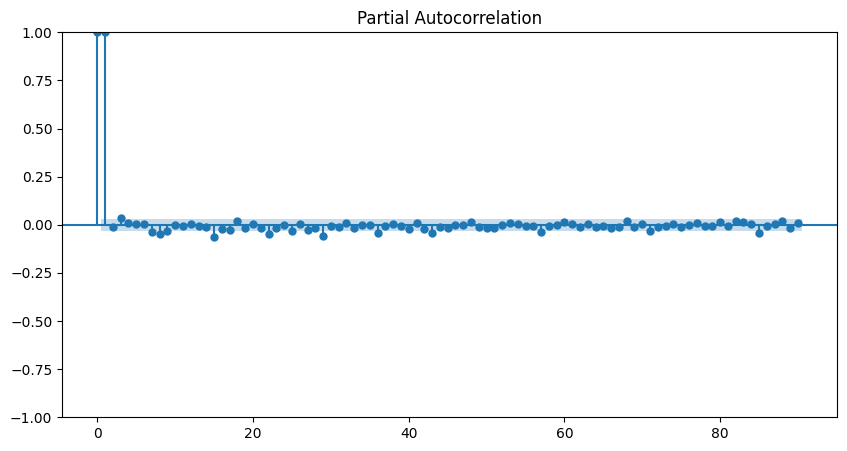

In [27]:
# Plot the Partial Auto-correlation (ACF)
fig, ax = plt.subplots(figsize = (10, 5))
plot_pacf(ts['Depth_to_Groundwater'], lags = 90, ax = ax)
plt.show()

### Step 4. Model training

In [28]:
# Training and Test Split
periods = 180
train, test = ts.iloc[:-periods, 0], ts.iloc[-periods:, 0]

In [29]:
# Holt - Winters Model
model = ExponentialSmoothing(train,
                             trend    = 'add',
                             seasonal = 'add',
                             seasonal_periods = 360).fit()
predictions = model.forecast(steps=len(test))

In [30]:
# Function to assess model and visualize output

def model_assessment(train, test, predictions, chart_title):
  
  # Plot training, test, and forecast
  plt.figure(figsize=(10,4))
  plt.plot(train, label = 'Training')
  plt.plot(test,  label = 'Test')
  plt.plot(predictions, label = 'Forecast')
  plt.title(f'Train, Test and Predictions With {chart_title}')
  plt.legend()
  plt.show()
  
  # Calculating the MAE, RMSE and MAPE
  mae = mean_absolute_error(test, predictions)
  print(f'Mean Absolute Error: {mae:.2f}')
  rmse = mean_squared_error(test, predictions)
  print(f'Root Mean Squared Error: {rmse:.2f}')
  mape = mean_absolute_percentage_error(test, predictions)
  print(f'Mean Absolute Percentage Error: {100*mape:.2f} %')

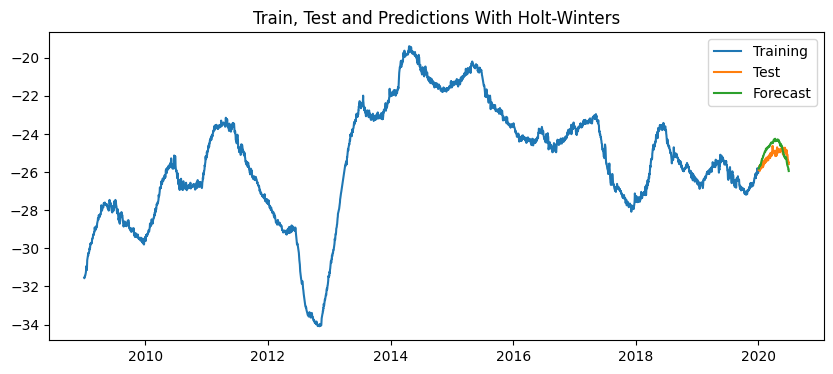

Mean Absolute Error: 0.43
Root Mean Squared Error: 0.22
Mean Absolute Percentage Error: 1.72 %


In [31]:
model_assessment(train, test, predictions, 'Holt-Winters')

### Step 5. Model prediction

In [32]:
# Holt - Winters Model
holt_win_model = ExponentialSmoothing(ts['Depth_to_Groundwater'],
                             trend    = 'add',
                             seasonal = 'add',
                             seasonal_periods = 360).fit()
forecast = holt_win_model.forecast(steps=360)

In [33]:
# Fuction to plot the future
def plot_future(y, forecast, title):
    # Plot training and forecasts
    plt.figure(figsize=(10,4))
    plt.plot(y, label = 'Training')
    plt.plot(forecast, label = 'Forecast')
    plt.title(f'Train and Forecast With {title}')
    plt.legend()
    plt.show()

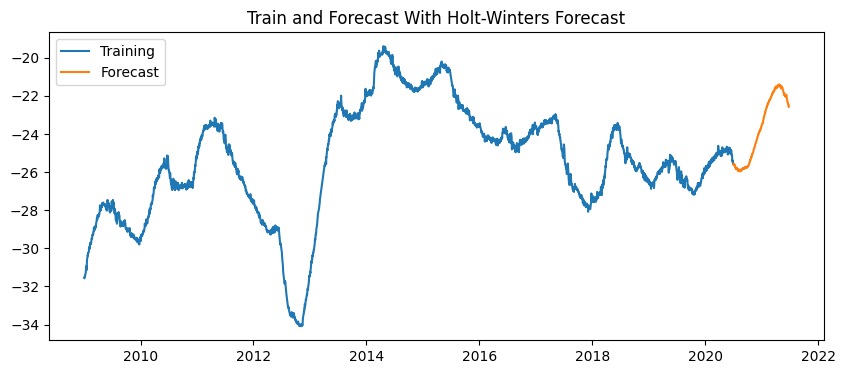

In [34]:
plot_future(ts['Depth_to_Groundwater'], forecast, 'Holt-Winters Forecast')

ARIMA model

In [35]:
# Perform ADF test

def check_stationary(time_series):
    result = adfuller(time_series)
    print('p-value: ', result[1])
    if result[1]<0.05:
        print("The evidence suggests that the time series is stationary.")
    else:
        print("The evidence suggests that the time series is not estatioanry")

In [36]:
check_stationary(ts['Depth_to_Groundwater'])

p-value:  0.06820766927021105
The evidence suggests that the time series is not estatioanry


In [37]:
ts_stationary = ts.diff().dropna()
check_stationary(ts_stationary)

p-value:  1.1204403407765432e-07
The evidence suggests that the time series is stationary.


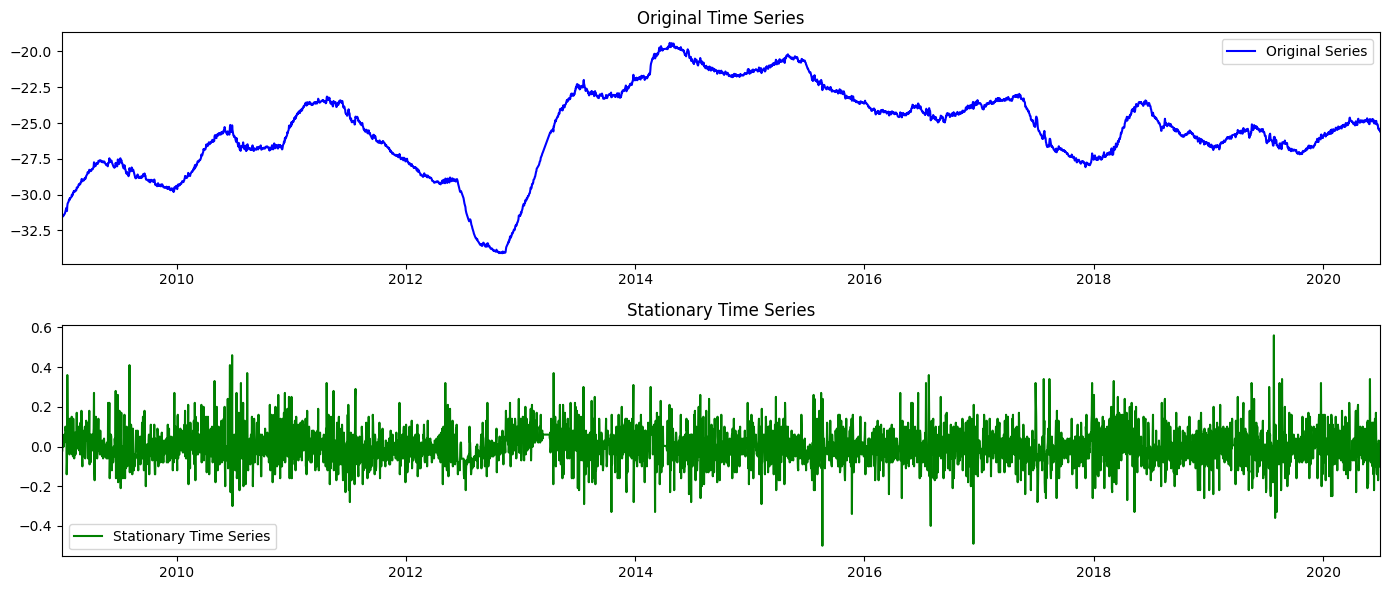

In [38]:
plt.figure(figsize=(14, 6))

# Plotting the original time series and the transformed time series 
        
plt.subplot(2, 1, 1)
plt.plot(ts['Depth_to_Groundwater'], label='Original Series', color='blue')
plt.title('Original Time Series')
plt.xlim(initial_date, final_date)
plt.legend()

# Subgráfico 2: Serie diferenciada

plt.subplot(2, 1, 2)
plt.plot(ts_stationary, label='Stationary Time Series', color='green')
plt.title('Stationary Time Series')
plt.xlim(initial_date, final_date)
plt.legend()

plt.tight_layout()
plt.show()

In [39]:
# Using pmdarima for the arima model and the best parameters
arima_model = auto_arima(train, seasonal = False
                        #start_p=0, start_q=0,
                        #max_p=5, maxq=5,
                        #m=7, #7-daily, 12-monthly, 52-weekly
                        #seasonal=False,
                        #d=None,
                        #trace=True,
                        #error_action='ignore',
                        #suppress_warnings=True,
                        #stepwise=True
                        )

In [40]:
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 4019
Model:               SARIMAX(5, 2, 3)   Log Likelihood                4048.761
Date:                Tue, 20 May 2025   AIC                          -8079.522
Time:                        03:10:01   BIC                          -8022.838
Sample:                    01-01-2009   HQIC                         -8059.434
                         - 01-02-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7908      0.100      7.883      0.000       0.594       0.987
ar.L2         -0.7298      0.067    -10.879      0.000      -0.861      -0.598
ar.L3         -0.0120      0.026     -0.459      0.647      -0.063       0.039
ar.L4         -0.1006      0.019     -5.216      0.000      -0.138      -0.063
ar.L5         -0.0449      0.022     -2.078      0.038      -0.087      -0.003
ma.L1         -1.8196      0.100    -18.280      0.000      -2.015      -1.625
ma.L2          1.4835      0.149      9.987      0.000       1.192       1.775
ma.L3         -0.6343      0.067     -9.426      0.000      -0.766      -0.502
sigma2         0.0078      0.000     64.296      0.000       0.008       0.008
===================================================================================
Ljung-Box (L1) (Q):                   0.55   Jarque-Bera (JB):              1151.30
Prob(Q):                              0.46   Prob(JB):                         0.00
Heteroskedasticity (H):               1.31   Skew:                             0.28
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.56
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [41]:
# Predictions
arima_predictions = arima_model.predict(n_periods = len(test))

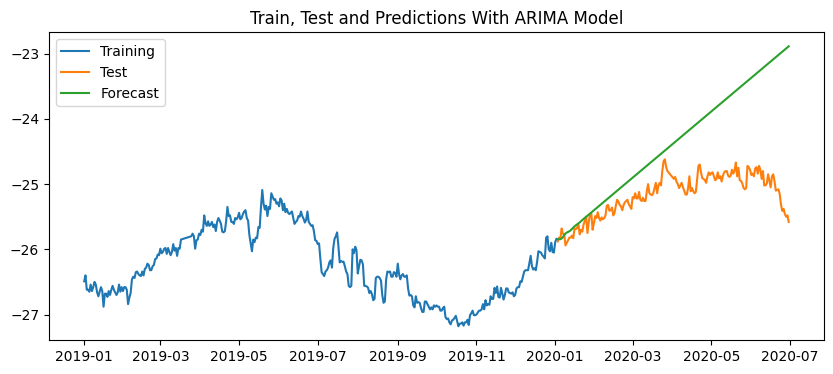

Mean Absolute Error: 0.79
Root Mean Squared Error: 1.06
Mean Absolute Percentage Error: 3.16 %


In [42]:
model_assessment(train['2019':], test, arima_predictions, "ARIMA Model")

SARIMA Model

In [43]:
# Using pmdarima for the sarima model and the best parameters
sarima_model = auto_arima(train, seasonal = True, trace = True
                        #start_p=0, start_q=0,
                        #max_p=5, maxq=5,
                        #m=7, #7-daily, 12-monthly, 52-weekly
                        #seasonal=False,
                        #d=None,
                        #trace=True,
                        #error_action='ignore',
                        #suppress_warnings=True,
                        #stepwise=True
                        )

Performing stepwise search to minimize aic


 ARIMA(2,2,2)(0,0,0)[0]             : AIC=-8059.373, Time=2.08 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=-5204.764, Time=0.10 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=-6135.760, Time=0.12 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=-7959.332, Time=0.44 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=inf, Time=1.96 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=-8006.447, Time=0.98 sec
 ARIMA(3,2,2)(0,0,0)[0]             : AIC=-8031.249, Time=2.77 sec
 ARIMA(2,2,3)(0,0,0)[0]             : AIC=-8040.130, Time=2.89 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=-7958.506, Time=0.85 sec
 ARIMA(1,2,3)(0,0,0)[0]             : AIC=-8059.591, Time=2.09 sec
 ARIMA(0,2,3)(0,0,0)[0]             : AIC=-8020.495, Time=1.31 sec
 ARIMA(1,2,4)(0,0,0)[0]             : AIC=-8025.362, Time=2.29 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=-7958.854, Time=0.86 sec
 ARIMA(0,2,4)(0,0,0)[0]             : AIC=-8044.503, Time=1.65 sec
 ARIMA(2,2,4)(0,0,0)[0]             : AIC=-8072.436, Time=3.14 sec
 

In [44]:
sarima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 4019
Model:               SARIMAX(2, 2, 4)   Log Likelihood                4043.218
Date:                Tue, 20 May 2025   AIC                          -8072.436
Time:                        03:10:53   BIC                          -8028.348
Sample:                    01-01-2009   HQIC                         -8056.811
                         - 01-02-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3118      0.043     -7.168      0.000      -0.397      -0.227
ar.L2          0.6532      0.044     14.751      0.000       0.566       0.740
ma.L1         -0.6978      0.045    -15.440      0.000      -0.786      -0.609
ma.L2         -1.0424      0.029    -35.370      0.000      -1.100      -0.985
ma.L3          0.6548      0.046     14.102      0.000       0.564       0.746
ma.L4          0.1072      0.017      6.284      0.000       0.074       0.141
sigma2         0.0078      0.000     66.108      0.000       0.008       0.008
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              1281.38
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.24   Skew:                             0.33
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.69
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [45]:
# Predictions
sarima_predictions = sarima_model.predict(n_periods = len(test))

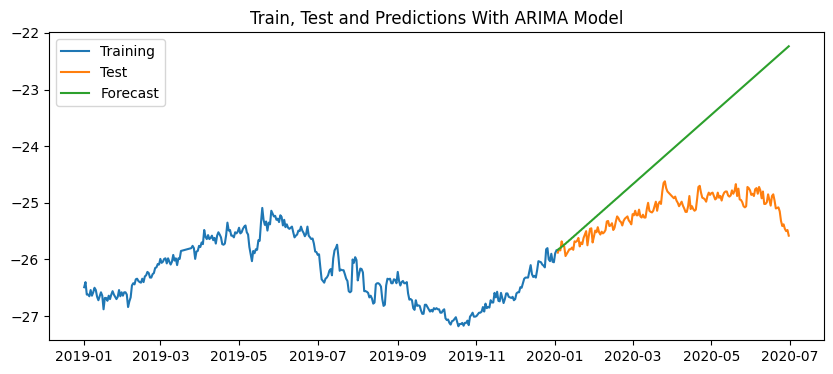

Mean Absolute Error: 1.13
Root Mean Squared Error: 1.97
Mean Absolute Percentage Error: 4.51 %


In [46]:
model_assessment(train['2019':], test, sarima_predictions, "ARIMA Model")